In [122]:
# Imports for Grady's NN Files
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

# My Imports
import csv
import time
import random
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn import neural_network

__Note:__ We're interested in the algorithms' ability to follow an "optimal" (for now random) path, so we don't need to generate them in _real time_. Which makes it ok to pre-compute the waypoints as opposed to generate them on the fly.

## Path Generation Based on Ellipse

In [3]:
# Using an ellipse because that resembles the shape of the track
def generateWaypoints():
    #Use equation for ellipse to plot points around an ellipse
    #Randomize the points along x and y slightly to generate random waypoints
    pass

## Path Generation Based on Existing Wayponts

In [14]:
# Getting existing waypoints
fileName = 'Waypoints.txt'
def getWaypoints(fileName):
    f = open(fileName, 'r')
    r = csv.reader(f, delimiter=',')
    xy = [row for row in r]
    x = [float(row[0]) for row in xy]
    y = [float(row[1]) for row in xy]
    f.close()
    return x, y 

# Generating new randomized waypoints from 
def generateWaypoints2(fileName, var):
    x, y = getWaypoints(fileName)
    xnew = [(i + random.uniform(-var, var)) for i in x]
    ynew = [(i + random.uniform(-var, var)) for i in y]
    return xnew, ynew

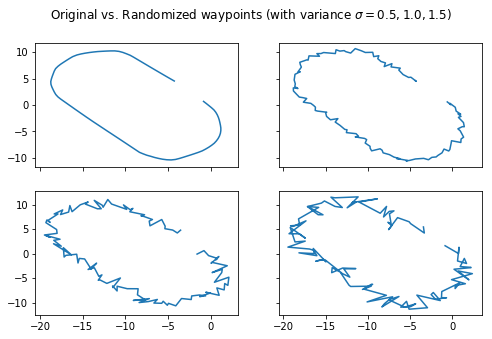

In [66]:
waypoints = 'Waypoints.txt'
x, y = getWaypoints(waypoints)
xrand1, yrand1 = generateWaypoints2(waypoints, 0.5)
xrand2, yrand2 = generateWaypoints2(waypoints, 1.0)
xrand3, yrand3 = generateWaypoints2(waypoints, 1.5)

# Plotting
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5), sharex='col', sharey='row')
f.suptitle(r'Original vs. Randomized waypoints (with variance $\sigma = 0.5, 1.0, 1.5$)')
ax1.plot(x, y)
ax2.plot(xrand1, yrand1)
ax3.plot(xrand2, yrand2)
ax4.plot(xrand3, yrand3)

# PROBLEM: Doing it this way, you sometimes get waypoints that go backwards if the variance is too high!
# SOLUTION? I could try to find a line perpendicular to the track at each point and generate the randomized point along that, 
# which may be a lot of work. I'll stick to just using a variance of 0.5 for now.

## Throttle PID Controller (2D Cartesian)
__Note:__ May need to implement smoothing depending on how well this runs

In [77]:
# Defining random gains
kp = 0.01
ki = 0.0002
kd = 0.005
ITermMin = 0
ITermMax = 2

# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The PID value to apply, the position error (for future D calculations)
def throttlePID(xcur, ycur, xdesired, ydesired, changingPoint, lastError, dtime):
    # 1. Determine target position
    ## No need if I set that as an input
    
    # 2. Find error based on absolute distance between current position and desired position
    positionError = np.sqrt((ydesired - ycur)**2 + (xdesired - xcur)**2)
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * positionError
    
    ## I
    if(changingPoint):                # Not sure this is actually the correct way to handle the constant positive I problem
        ITerm = ITermMin
        changingPoint = False
    ITerm += ki * positionError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dposition = (positionError - lastError) / dtime
    DTerm = kd * dposition;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, positionError)

In [83]:
# Testing Throttle PID: Creating an array of all the PID values that would be output if the car was exactly at every point
#                       (not in between) and wanted to reach the exact next point. Also assigns the past error as 0 and the 
#                       difference in time since last calculation 0.1,
PIDAtPoints = []
for i, j in zip(range(0, len(xrand1) - 1), range(0, len(yrand1)-1)):
    sumPID, pastError = throttlePID(xrand1[i], yrand1[j], xrand1[i + 1], yrand1[j + 1], True, 0, 0.1)
    PIDAtPoints.append(sumPID)
    
#print(PIDAtPoints)
# NOTE: This just shows that the throttlePID function correctly outputs different PID values 

## Neural Network State Estimator (Grady's stuff)

In [116]:
# Check if you can input weights for scikit learns MLPRegressor to use the stuff Grady sent.

In [84]:
class AutoRallyNet:

    def __init__(self, save_path, dt = 0.02):
        self.weight_dict = np.load(save_path)
        self.non_linearity = np.tanh
        self.dt = dt
    
    def __call__(self, x, steering, throttle):
        state = np.copy(x) #Don't modify x, return updated state as new variable
        #First compute the state derivative
        fn_input = np.concatenate([state[3:], [steering], [throttle]])
        h1 = np.dot(self.weight_dict["dynamics_W1"], fn_input) + self.weight_dict["dynamics_b1"]
        h1 = np.tanh(h1)
        h2 = np.dot(self.weight_dict["dynamics_W2"], h1) + self.weight_dict["dynamics_b2"]
        h2 = np.tanh(h2)
        state_der = np.dot(self.weight_dict["dynamics_W3"], h2) + self.weight_dict["dynamics_b3"]
        #Now compute the actual state update
        state[0] += (np.cos(state[2])*state[4] - np.sin(state[2])*state[5])*self.dt
        state[1] += (np.sin(state[2])*state[4] + np.cos(state[2])*state[5])*self.dt
        state[2] += -state[6]*self.dt #Sixth state is NEGATIVE of yaw derivative
        state[3] += state_der[0]*self.dt
        state[4] += state_der[1]*self.dt
        state[5] += state_der[2]*self.dt
        state[6] += state_der[3]*self.dt
        return state

In [ ]:
def animate(npy_array, name):
    save_as = name + ".mp4"
    Xs = npy_array[:, 0]
    Ys = npy_array[:, 1]
    Yaw = npy_array[: ,2]
    Vx = npy_array[:, 4]
    Vy = npy_array[:, 4]*np.tan(npy_array[:, 3])
    T = range(Xs.size)
    fig = plt.figure()
    ax = plt.axes(xlim=(0,20), ylim = (-10,10))
    Xs = np.array(Xs)
    Ys = np.array(Ys)
    lines = []
    line, = ax.plot([],[])
    circs = []
    circs.append(Rectangle((Xs[0] - .30, Ys[0] - .13), .6, .26, color = 'r'))
    def init():
        line.set_data([], [])
        for c in circs:
            ax.add_patch(c)
        return circs,
    def animate(k):
        for c in circs:
            heading = Yaw[k]/np.pi * 180.0
            t = mpl.transforms.Affine2D().rotate_deg_around(Xs[k], Ys[k], heading) + ax.transData
            c.set_transform(t)
            c.set_xy((Xs[k] - .3, Ys[k] - .13))
        x = np.copy(Xs[:k])
        y = np.copy(Ys[:k])
        sys.stdout.write("Making Animation: %d/%d \r" % (k, len(Xs)))
        sys.stdout.flush()
        line.set_data(x,y)
        line.set_alpha(.1)
        return circs,
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames = len(Xs), interval=20,blit=True)
    anim.save(save_as, fps=50, writer='avconv', bitrate = 2500)

if __name__ == "__main__":
    steering = np.clip(np.random.randn(250), -1, 1)        # Generates values from the normal distribution clamped between [-1 1]
    throttle = np.clip(np.random.randn(250), -1, 0.75)
    x = np.array([0, 0, 0, 0, 5.0, 0.5, 0])
    state_history = []

    f = AutoRallyNet("alpha_nnet.npz")

    for i in range(250):
        state_history.append(x)
        x = f(x, steering[i], throttle[i])

    animate(np.asarray(state_history), "random_controls")

In [115]:
#f = AutoRallyNet("alpha_nnet.npz")
non_linearity = np.tanh


-1.0

## MAIN LOOP

In [ ]:
# Generate waypoints ahead of time, store them in x and y
changingPoint = True    # May need this for the integral term to know when to reset it to 0 (think about this! Depending on how
                        # you define the addition to the integral term, it may always be positive, e.g. if the next point is 
                        # always ahead, then you'll always add a positive value so Iterm will just grow larger and larger.. bad!)
def runPID():
    targetIndex = 1
    keepGoing = True
    xCurr, yCurr = xrand1[0], yrand1[0]
    xTarget, yTarget = xrand1[currTarget], yrand1[currTarget]
    proxThreshold = 0.15    # If rally is within that distance from target, set next point as target
    
    # Start timer and loop
    startTime = time.time()
    while(keepGoing):
        # 1. Our current and target x and y are defined, if we're close enough to the desired, change target to the next position
        distanceToTarget = np.sqrt((xTarget - xCurr)**2, (yTarget - yCurr)**2)
        if (distanceToTarget < 0.15):
            target
            xTarget, yTarget = xrand1[currTarget], yrand1[currTarget]
        
        # 2. Compute PID (to get to next waypoint)
        # 3. Apply that PID and use the NN to estimate new position
        # 4. Repeat these steps, PROBLEM: Do it time or space based? SOLUTION? Try time interval of 0.1s first (edge case is if we're not moving, handle that too)
        
        # 5. Stop running after however long/many laps you want
        currTime = time.time()
        if (currTime - startTime >= 2):
            keepGoing = False

<br>
<br>
##### Useful Plotting Stuff

In [ ]:
axes = plt.gca()
#axes.set_ylim([-10, 15])
#axes.set_xlim([-18, -4])
#plt.gca().invert_xaxis()
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))